In [27]:
!python --version

Python 3.7.10


In [28]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
import matplotlib.pyplot as plt


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

rdkit is already installed
rdkit is already installed


In [29]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdchem
from rdkit.Chem import Draw

import re


In [30]:
!pip install mordred

# feature.py code

In [31]:
from rdkit import Chem
import numpy as np
import pandas as pd
import pickle
from mordred import Calculator, descriptors

# Credit: http://www.dna.bio.keio.ac.jp/smiles/

# xp = np

#
Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

 # featurevector
atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

#
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

#
upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

#
def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]

    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)

def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)

def calc_featurevector(mol, smiles, atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def isomer_smiles(mol,n):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return isomerSMILES


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES, atomsize)


def mol_to_allSMILESfeature(mol, atomsize):
    idx, features =0,  []
    while idx < mol.GetNumAtoms():
        try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(idx))
        except: break
        isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(idx))
        features.append(calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES, atomsize))
        idx = idx + 1
    return(features)


def atom_flag(smiles,atomsize):
    flag=[]
    j = 0
            
    for c in smiles:
        if islower(c) == True: 
            if c in ['c', 'n', 's', 'o']:
                flag.append(1)
            else:
                flag.append(0)
        elif isupper(c) == True:
            if c in ['H',]:
                flag.append(0)
            else:
                flag.append(1)
        else:   
            flag.append(0)           

    #0-Padding
    flag.extend([0]*(atomsize-len(smiles)))        
    return(flag)

In [32]:
from tqdm import tqdm
from rdkit import Chem
import numpy as np
import pandas as pd
import pickle
from mordred import Calculator, descriptors

In [33]:
!gdown --id 1EM5skz4TfnLk3JZSt-tKKadYFoPeYty7

Downloading...
From: https://drive.google.com/uc?id=1EM5skz4TfnLk3JZSt-tKKadYFoPeYty7
To: /content/SF17_ViralChEMBL_dataset.csv
251MB [00:01, 169MB/s]


In [34]:
db = pd.read_csv('/content/SF17_ViralChEMBL_dataset.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
HIV1 = 2938
HCV = 1620
FluA = 2168

In [36]:
def process_species_data(db, species_id, name):
    species_ds = db[(db.species_id == species_id) & (db.av_act50.notna())]
    
    assays_data = species_ds.groupby(['assay_chembl_id', 'molregno'])[['av_act50', 'canonical_smiles']].nunique() 
    n_assays = assays_data.shape[0]
    n_controversial_assays = assays_data[assays_data.av_act50 > 1].shape[0]
    
    print(f'Percentage of controversial assays: {n_controversial_assays/n_assays * 100:.3}%')
    
    for (chembl_id, mol) in (assays_data[assays_data.av_act50 > 1]).index.values:
        species_ds = species_ds[~((species_ds.assay_chembl_id == chembl_id) & (species_ds.molregno == mol))]
        
    species_ds.groupby('molregno').av_act50.mean().hist(bins=10)
    plt.title(f'Inter-assays agreement on\nanti-{name} molecule activity', fontsize=14)
    plt.ylabel('Number of molecules', fontsize=14)
    plt.xlabel('% of assays confirming the antiviral activity', fontsize=14)
    plt.show()
    
    indices = species_ds.groupby('molregno').av_act50.mean()[species_ds.groupby('molregno').av_act50.mean() > 0.5].index.values
    species_ds = species_ds[species_ds.molregno.isin(indices)]
    
    species_ds.canonical_smiles.apply(len).hist(bins=100)
    plt.title(f'Distribution of {name}-active molecules smiles length', fontsize=14)
    plt.ylabel('Number of molecules', fontsize=14)
    plt.xlabel('Smiles length', fontsize=14)
    plt.show()
    
    species_ds = species_ds[species_ds.canonical_smiles.apply(len) <= 250]
        
    return species_ds

Percentage of controversial assays: 0.0632%


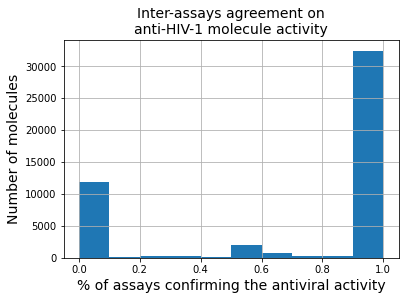

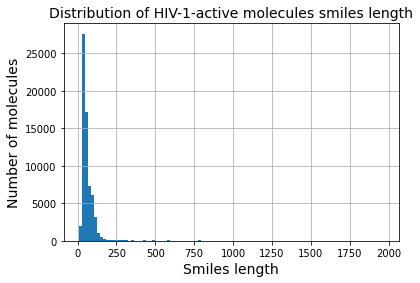

In [37]:
hiv1_ds = process_species_data(db, HIV1, 'HIV-1')

Percentage of controversial assays: 0.0735%


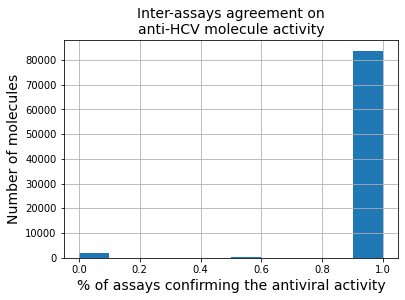

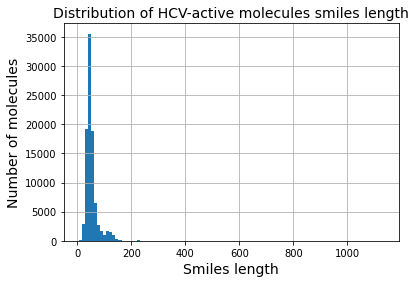

In [38]:
hcv_ds = process_species_data(db, HCV, 'HCV')

Percentage of controversial assays: 0.0217%


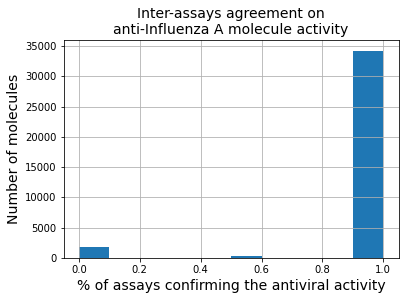

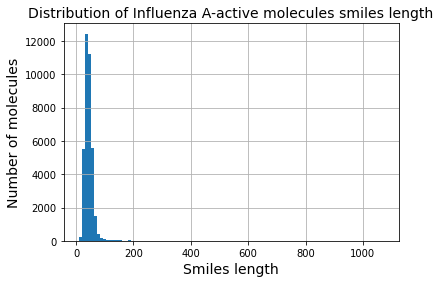

In [39]:
flua_ds = process_species_data(db, FluA, 'Influenza A')

# Intersections

In [40]:
import matplotlib
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles

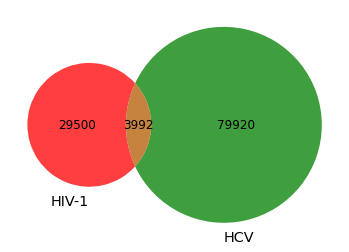

In [41]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(6,6))
out = venn2([set(hiv1_ds.molregno.values), set(hcv_ds.molregno.values)], 
      set_labels = ('HIV-1', 
                    'HCV'),
      set_colors = ('r', 'g'),
      alpha=0.75)
plt.show()

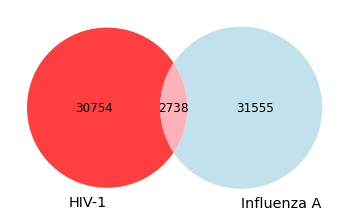

In [42]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(6,6))
out = venn2([set(hiv1_ds.molregno.values), set(flua_ds.molregno.values)], 
      set_labels = ('HIV-1', 
                    'Influenza A'),
      set_colors = ('r', 'lightblue'),
      alpha=0.75)
plt.show()

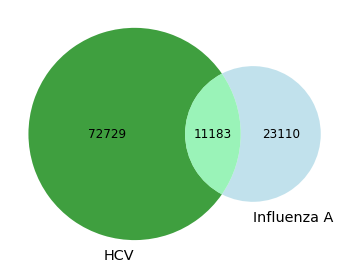

In [43]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(6,6))
out = venn2([set(hcv_ds.molregno.values), set(flua_ds.molregno.values)], 
      set_labels = ('HCV', 
                    'Influenza A'),
      set_colors = ('g', 'lightblue'),
      alpha=0.75)
plt.show()

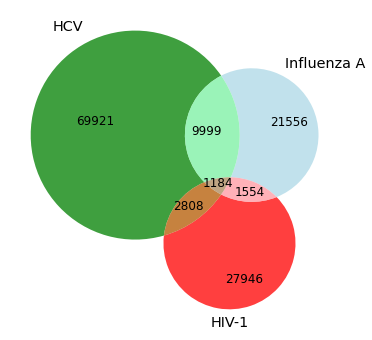

In [44]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(6,6))
out = venn3([set(hcv_ds.molregno.values), set(flua_ds.molregno.values), set(hiv1_ds.molregno.values)], 
      set_labels = ('HCV', 
                    'Influenza A',
                    'HIV-1'),
      set_colors = ('g', 'lightblue', 'r'),
      alpha=0.75)
plt.show()

# Datasets

In [45]:
# an example of dataset creation
# any species dataset could be used instead of hiv1_ds, hcv_ds 
hiv1_hcv = pd.concat([hiv1_ds[['canonical_smiles', 'species_id']].drop_duplicates(),
                      hcv_ds[['canonical_smiles', 'species_id']].drop_duplicates()])

In [46]:
intersec = hiv1_hcv.groupby('canonical_smiles').species_id.nunique()
intersec = intersec[intersec > 1]

In [51]:
hiv1_hcv = hiv1_hcv[~hiv1_hcv.canonical_smiles.isin(intersec.index.values)]

In [53]:
!gdown --id 16S-QJGH0vWtmhB0ONF0cFyyoNmObusd8

Downloading...
From: https://drive.google.com/uc?id=16S-QJGH0vWtmhB0ONF0cFyyoNmObusd8
To: /content/mord_keys.csv
100% 6.21k/6.21k [00:00<00:00, 2.54MB/s]


In [54]:
custom_descriptors = pd.read_csv('mord_keys.csv')['mord_keys'].values.tolist()

In [55]:
# !!!the following code can take a long time and a lot of memory 
# running on subset 

In [56]:
hiv1_hcv = hiv1_hcv.head(200) # comment this line to get a full dataset

In [57]:
mols = [Chem.MolFromSmiles(i) for i in hiv1_hcv.canonical_smiles]
calc = Calculator(descriptors, ignore_3D=True)

In [58]:
md = calc.pandas(mols)

 18%|█▊        | 36/200 [00:29<03:09,  1.16s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 44%|████▍     | 88/200 [01:14<02:56,  1.58s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


In [59]:
md = md[custom_descriptors]

In [60]:
iso_smiles = [isomer_smiles(mol,-1) for mol in mols]

In [61]:
MAX_LEN = max([len(x) for x in iso_smiles])
MAX_LEN

187

In [62]:
smile_ft = [mol_to_feature(mol,-1, MAX_LEN) for mol in mols]

In [63]:
md['smile_ft'] = smile_ft
md['active'] = hiv1_hcv.species_id.apply(lambda x: 1 if x == HIV1 else 0).values.tolist()

In [64]:
md.to_csv('hiv1_hcv_temp.csv', index=False)
hiv1_hcv_final = pd.read_csv('hiv1_hcv_temp.csv')

In [65]:
# when working with full dataset, reading hiv1_hcv_final will return you warning
# DtypeWarning: Columns (4,5,6, ...) have mixed types. Specify dtype option on import or set low_memory=False.
# copy all the listed columns to bad_cols list 
bad_cols = []

In [66]:
to_drop = set()
for c in bad_cols:
    col = hiv1_hcv_final.columns.values[c]
    # col contains numbers and string - the error message
    # taking max value will return you this error message
    bad_val = max(hiv1_hcv_final[col].apply(str).values)
    to_drop = to_drop.union(set(hiv1_hcv_final[hiv1_hcv_final[col] == bad_val].index.values))

hiv1_hcv_final = hiv1_hcv_final.drop(to_drop, axis=0)

In [67]:
hiv1_hcv_final.to_csv('hiv1_hcv.csv', index=False)